# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    423      0 --:--:-- --:--:-- --:--:--   422
100 1546k  100 1546k    0     0  1189k      0  0:00:01  0:00:01 --:--:-- 9152k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    866      0 --:--:-- --:--:-- --:--:--   866
100  385k  100  385k    0     0   534k      0 --:--:-- --:--:-- --:--:--  534k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    997      0 --:--:-- --:--:-- --:--:--   997
100  230k  100  230k    0     0   327k      0 --:--:-- --:--:-- --:--:--  327k


In [2]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1MB 4.3MB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3420067 sha256=12a3cb4639916e3c42642260fbfc2681658cc27906fd473062c47be591d233a3
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [19]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse
import matplotlib.pyplot as plt

In [4]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [5]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [6]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [7]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [8]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [10]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [11]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [12]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [13]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [14]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [15]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:**

ALS busca generar la una matriz de interacciones entre usuarios e items a través de la multiplicación de un vector que representa usuarios y otro que representa items. La gracia del algoritmo es que actualiza estos vectores de manera alternada para reducir así el RMSE.

In [16]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [17]:
show_recommendations(model_als, user=77, n=10)

movieid
258                                        Contact (1997)
754                                     Red Corner (1997)
257                                   Men in Black (1997)
256     When the Cats Away (Chacun cherche son chat) (...
49                                            I.Q. (1994)
1012                                 Private Parts (1997)
126                            Spitfire Grill, The (1996)
1026                          Lay of the Land, The (1997)
1045                                      Fearless (1993)
864                            My Fellow Americans (1996)
Name: title, dtype: object

In [18]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.06303198889673915
ndcg: 0.34150076569678406


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

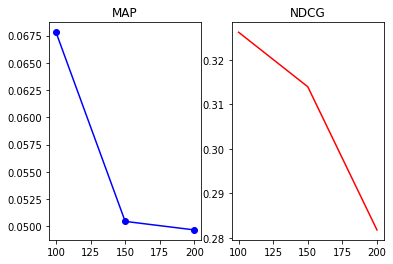

In [21]:
factors = [100, 150, 200]
maps = []
ndcgs = []

for f in factors:
    model_als = implicit.als.AlternatingLeastSquares(factors=f, iterations=10, use_gpu=False)
    model_als.fit(matrix)
    
    map, ndcg = evaluate_model(model_als, n=10)
    
    maps.append(map)
    ndcgs.append(ndcg)

plt.subplot(1, 2, 1)
plt.title('MAP')
plt.plot(factors, maps, 'bo-')

plt.subplot(1, 2, 2)
plt.title('NDCG')
plt.plot(factors, ndcgs, 'r-')

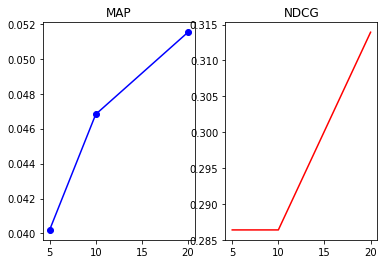

In [22]:
its = [5, 10, 20]
maps = []
ndcgs = []

for f in its:
    model_als = implicit.als.AlternatingLeastSquares(factors=200, iterations=f, use_gpu=False)
    model_als.fit(matrix)
    
    map, ndcg = evaluate_model(model_als, n=10)
    
    maps.append(map)
    ndcgs.append(ndcg)

plt.subplot(1, 2, 1)
plt.title('MAP')
plt.plot(its, maps, 'bo-')

plt.subplot(1, 2, 2)
plt.title('NDCG')
plt.plot(its, ndcgs, 'r-')

In [23]:
model_als = implicit.als.AlternatingLeastSquares(factors=200, iterations=5, use_gpu=False)
model_als.fit(matrix)

map, ndcg = evaluate_model(model_als, n=10)

print(f'MAP: {map}\nNDCG: {ndcg}')


MAP: 0.045984625226571235
NDCG: 0.29555895865237364


## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.

**Respuesta**

BPR represents interactions between users and items on a matrix. Then for each user, it builds a item-item matrix to represent the estimation of preference of one item over another.

In [24]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [25]:
show_recommendations(model_bpr, user=77, n=10)

movieid
285            Secrets & Lies (1996)
257              Men in Black (1997)
299                   Hoodlum (1997)
327                  Cop Land (1997)
300             Air Force One (1997)
332            Kiss the Girls (1997)
267                          unknown
244    Smilla's Sense of Snow (1997)
746               Real Genius (1985)
676             Crucible, The (1996)
Name: title, dtype: object

In [26]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171          Delicatessen (1991)
209    This Is Spinal Tap (1984)
68              Crow, The (1994)
194            Sting, The (1973)
203            Unforgiven (1992)
201          Evil Dead II (1987)
78             Free Willy (1993)
95                Aladdin (1992)
27               Bad Boys (1995)
30          Belle de jour (1967)
Name: title, dtype: object

In [27]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.05394966822479034
ndcg: 0.35068912710566613


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

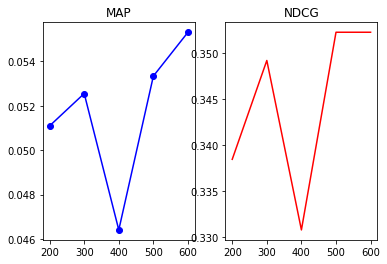

In [29]:
factors = [200, 300, 400, 500, 600]
maps = []
ndcgs = []

for f in factors:
    model_als = implicit.bpr.BayesianPersonalizedRanking(factors=f, iterations=40, use_gpu=False)
    model_als.fit(matrix)
    
    map, ndcg = evaluate_model(model_als, n=10)
    
    maps.append(map)
    ndcgs.append(ndcg)

plt.subplot(1, 2, 1)
plt.title('MAP')
plt.plot(factors, maps, 'bo-')

plt.subplot(1, 2, 2)
plt.title('NDCG')
plt.plot(factors, ndcgs, 'r-')

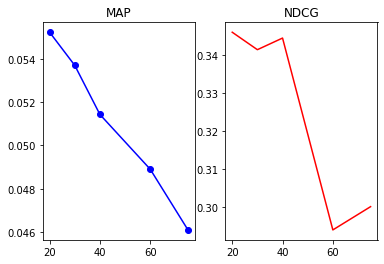

In [31]:
its = [20, 30, 40, 60, 75]
maps = []
ndcgs = []

for f in its:
    model_als = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=f, use_gpu=False)
    model_als.fit(matrix)
    
    map, ndcg = evaluate_model(model_als, n=10)
    
    maps.append(map)
    ndcgs.append(ndcg)

plt.subplot(1, 2, 1)
plt.title('MAP')
plt.plot(its, maps, 'bo-')

plt.subplot(1, 2, 2)
plt.title('NDCG')
plt.plot(its, ndcgs, 'r-')